In [1]:
import pandas as pd

import torch
from torch import nn
from torch import Tensor
import math
import configparser
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch import cuda
import elastictransformer as st

c:\Users\trzci\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
dataset = st.CustomDataSet('ETTm2.csv',window_length=720,prediction_window=96,require_date_split=False)

['day', 'month', 'year', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


In [2]:
dataset = st.CustomDataSet('ETTm2.csv',window_length=720,prediction_window=96,require_date_split=False)
#keep this separate (in case it's needed)
flow_control_dataset = st.CustomDataSet('ETTm2.csv',window_length=720,prediction_window=96,require_date_split=False)

params = st.ParameterProvider("series-ettm.config")
t1 = st.ElasticTransformer(params)
device_id = torch.cuda.current_device()
t1.cuda(device_id)
train_dataset, test_dataset = dataset.getSets()
#_, loss_history = st.train_cuda(t1, train_dataset, device_id, epochs = 3, verbose_delay=-1)


epochs = 0
total_epochs = 800
increment = 10
vertical_control_delay = 40

losses = []
r_square = []
mean_prunabilities = []
mean_dims = []


head_limit = 8
stack_limit = 16

['day', 'month', 'year', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
['day', 'month', 'year', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


In [3]:
loss_history = []
objective_history_training = []
objective_history_validation = []

In [4]:
target_dim_threshold = 0.3
target_dim_threshold_upper = 0.6

target_norm_threshold = 0.1
target_norm_threshold_upper = 2.0

optimizer = torch.optim.Adam(t1.parameters())

In [6]:
while epochs < total_epochs:

    for e in range(increment):
        t1.setTracking(False)
        running_loss = 0.0
        loss_length = 0
        _, losses = st.train_cuda(t1, train_dataset, device_id, epochs = 1, verbose_delay=-1,optimizer=optimizer)
        print('Epoch: ', epochs, ' running loss: ', losses[-1])
        loss_history.append(losses[-1])
        epochs +=1
    
    t1.clearMemory()

    with torch.no_grad():
        t1.setTracking(True)
        validation = st.validate_cuda(t1,flow_control_dataset,device_id,batch_size=1440)

        t1.assignHorizontalRedundanceScores()
        t1.assignVerticalRedundanceScores()
        print('Scores assigned')
        t1.setTracking(False)



    print('hris (encoders)')
    for e in t1.encoder_stack.encoders:
        #hri = e.mha.output_memory.dimenisonal_reductability
        hri = math.sqrt(e.mha.output_memory.dimenisonal_reductability*e.mha.output_memory.pruningability)
        print(hri)
        if hri < target_dim_threshold and len(e.mha.heads) < head_limit:
            e.mha.add_head_horizontal()
        if hri > target_dim_threshold_upper:
            if len(e.mha.heads) > 1:
                e.mha.remove_head_horizontal()
    
    print('hris (decoders)')
    for d in t1.decoder_stack.decoders:
        #hri = d.mha.output_memory.dimenisonal_reductability
        hri = math.sqrt(d.self_mha.output_memory.dimenisonal_reductability*d.self_mha.output_memory.pruningability)
        print(hri)
        if hri < target_dim_threshold and len(d.self_mha.heads) < head_limit :
            d.self_mha.add_head_horizontal()
            print('adding a head')
        if hri > target_dim_threshold_upper:
            if len(d.self_mha.heads) > 1:
                d.self_mha.remove_head_horizontal()
                print('removing a head')

        hri = math.sqrt(d.ed_mha.output_memory.dimenisonal_reductability*d.ed_mha.output_memory.pruningability)
        print(hri)
        if hri < target_dim_threshold and len(d.ed_mha.heads) < head_limit:
            d.ed_mha.add_head_horizontal()
            print('adding a head')
        if hri > target_dim_threshold_upper:
            if len(d.ed_mha.heads) > 1:
                d.ed_mha.remove_head_horizontal()
                print('removing a head')

    print('heads:')
    print('encoders:')
    for e in t1.encoder_stack.encoders:
        print(len(e.mha.heads))
    print('decoders:')
    for d in t1.decoder_stack.decoders:
        print(len(d.self_mha.heads), ',', len(d.ed_mha.heads))

    sum_of_heads = 0
    sum_of_mhas = 0
    for e in t1.encoder_stack.encoders:
        sum_of_heads += len(e.mha.heads)
    sum_of_mhas += len(t1.encoder_stack.encoders)
    for d in t1.decoder_stack.decoders:
        sum_of_heads += len(d.ed_mha.heads)
        sum_of_heads += len(d.self_mha.heads)
    sum_of_mhas += 2*len(t1.decoder_stack.decoders)

    # update config to match the average head number:
    new_head_number = int(sum_of_heads/sum_of_mhas)

    if new_head_number > 0:
        t1.config.dictionary['n_heads'] = new_head_number


    if epochs % vertical_control_delay == 0:
        t1.assignVerticalRedundanceScores()

        print('vris')
        for i, e in enumerate(t1.encoder_stack.encoders):
            vri = e.vertical_redundance
            print(vri)
            if vri > target_norm_threshold_upper:
                head_number = len(e.mha.heads)
                #t1.add_encoder(i,head_number=head_number)
                t1.addEncoder(i)
                #t1.encoder_stack.encoders.insert(i, st.EncoderLayer(t1.config,randomize = True,head_number=head_number))
                print('Adding an encoder')
                break
            else:
                if vri < target_norm_threshold:
                    if len(t1.encoder_stack.encoders) > 1:
                        del t1.encoder_stack.encoders[i]
                        print('Deleting an encoder')
                        break

        for i, d in enumerate(t1.decoder_stack.decoders):
            print(d.vertical_redundance)
            if d.vertical_redundance > target_norm_threshold_upper:
                #t1.add_decoder(i,head_number=head_number)
                t1.addDecoder(i)
                print('Adding a decoder')
                break
            else:
                if d.vertical_redundance < target_norm_threshold:
                    if len(t1.decoder_stack.decoders) > 1:
                        del t1.decoder_stack.decoders[i]
                        print('Deleting a decoder')
                        break


    # we need to repeat this in case network has changed
    optimizer = torch.optim.Adam(t1.parameters())

Epoch 0 of 1
Epoch loss: 0.011343042486340228
Epoch:  10  running loss:  0.011343042486340228
Epoch 0 of 1
Epoch loss: 0.011188374453179082
Epoch:  11  running loss:  0.011188374453179082
Epoch 0 of 1
Epoch loss: 0.011836025091535796
Epoch:  12  running loss:  0.011836025091535796
Epoch 0 of 1
Epoch loss: 0.01280381315831002
Epoch:  13  running loss:  0.01280381315831002
Epoch 0 of 1
Epoch loss: 0.012238146549445803
Epoch:  14  running loss:  0.012238146549445803
Epoch 0 of 1
Epoch loss: 0.011907669270507673
Epoch:  15  running loss:  0.011907669270507673
Epoch 0 of 1
Epoch loss: 0.013795087804761472
Epoch:  16  running loss:  0.013795087804761472
Epoch 0 of 1
Epoch loss: 0.008662770199501546
Epoch:  17  running loss:  0.008662770199501546
Epoch 0 of 1
Epoch loss: 0.007545865378147867
Epoch:  18  running loss:  0.007545865378147867
Epoch 0 of 1
Epoch loss: 0.006768609986727858
Epoch:  19  running loss:  0.006768609986727858


MemoryError: Unable to allocate 2.96 GiB for an array with shape (49582080, 16) and data type float32

In [ ]:
loss_history

In [8]:
print('Structure')
print('Encoder stack: ')
for e in t1.encoder_stack.encoders:
    print(len(e.mha.heads))

print('Decoder stack: ')
for d in t1.decoder_stack.decoders:
    print(len(d.self_mha.heads), ' ', len(d.ed_mha.heads))

Structure
Encoder stack: 
1
Decoder stack: 
1   2


[0.021678136476952665, 0.015642852983125146, 0.008987492082627549, 0.008862806108220978, 0.0071529066040041086, 0.010942028024328254, 0.011117367865274359, 0.010888905564128908, 0.01010244375372762, 0.008456015588739199, 0.007449653007954892, 0.007411816567862644, 0.007441525109528438, 0.006993954333199002, 0.007085748222758225, 0.007397827376649659, 0.007821058981591385, 0.007217549490649091, 0.007020873026972373, 0.0067589684919654, 0.007511278676969982, 0.007172909182255426, 0.007522533102281193, 0.007339700737386145]


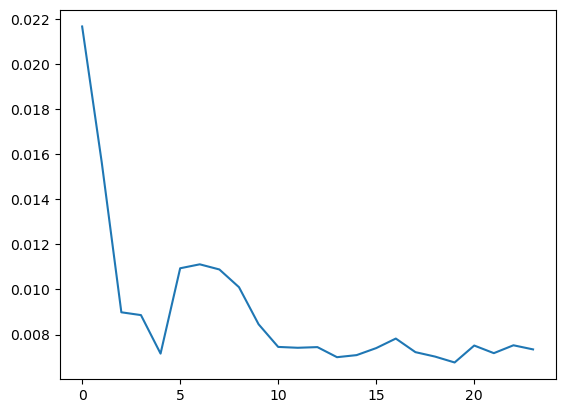

In [9]:
plt.plot(loss_history)
print(loss_history)
plt.show()

In [10]:
import pickle

In [11]:
filedump = open('t1-21-01-2024.pydump',"wb")

In [12]:
pickle.dump(t1, filedump)
filedump.close()

KeyboardInterrupt: 

[0.3058811165392399, 0.15646939165890217, 0.08948070369660854, 0.0635549109429121, 0.055799874011427164, 0.05102733103558421, 0.048745802603662014, 0.04691348480992019, 0.04554755333811045, 0.0448753172531724, 0.046460801269859076, 0.04621945065446198, 0.04370670043863356, 0.043978495290502906, 0.04268843331374228, 0.043034454341977835, 0.04189783870242536, 0.042013342725113034, 0.04131101677194238, 0.04144104477018118, 0.0403019986115396, 0.04123173304833472, 0.03990360954776406, 0.04066241765394807, 0.03947999561205506, 0.03979142499156296, 0.03889847360551357, 0.03900718875229359, 0.0381284668110311, 0.038268559612333775, 0.0380723406560719, 0.03720679646357894, 0.03652632609009743, 0.036370954010635614, 0.035789194982498884, 0.035601016134023666, 0.03480506641790271, 0.03431964828632772, 0.033416830003261566, 0.033128270180895925, 0.0391729474067688, 0.03784148278646171, 0.031112349592149258, 0.035958103369921446, 0.029422400053590536, 0.033809097949415445, 0.028128721518442035, 0.

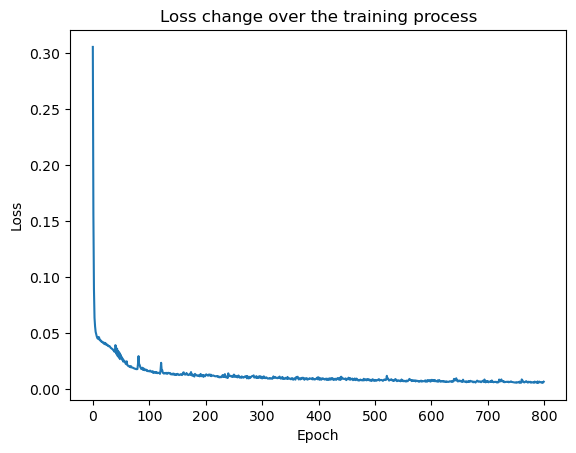

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss change over the training process')
print(loss_history)
plt.show()

R^2 tensor(-1.2287)


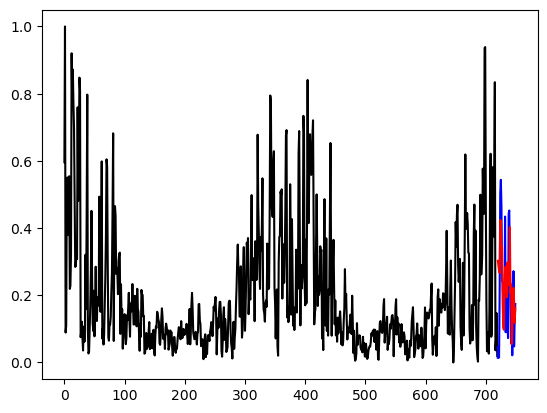

R^2 tensor(-2.6410)


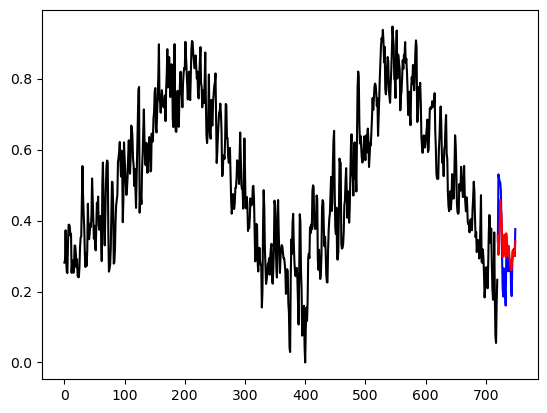

R^2 tensor(-0.3354)


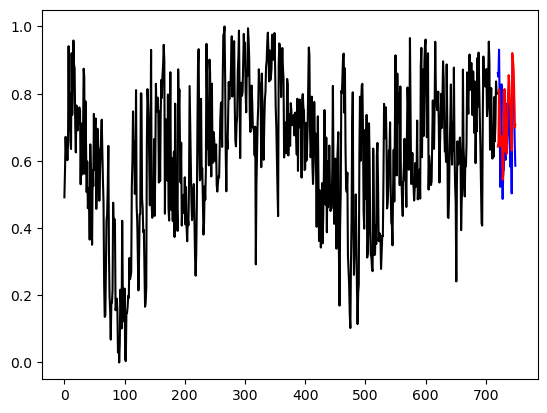

R^2 tensor(0.1825)


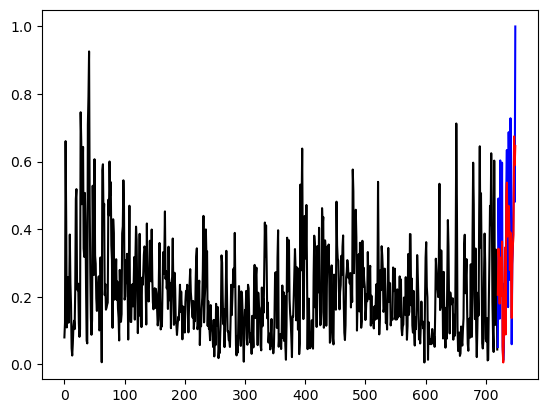

R^2 tensor(-5.5282)


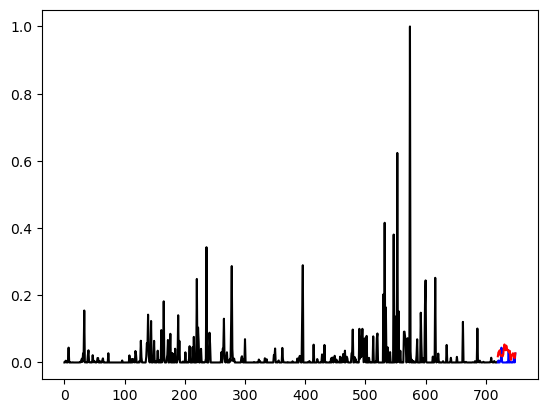

R^2 tensor(-507.8297)


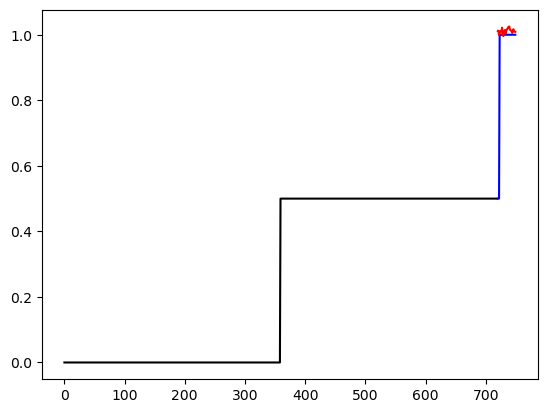

R^2 tensor(-47.8288)


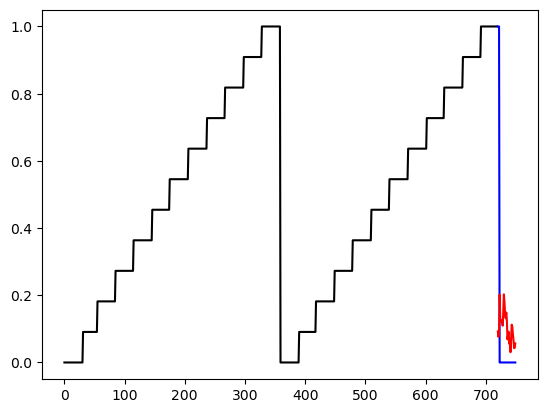

R^2 tensor(-0.1240)


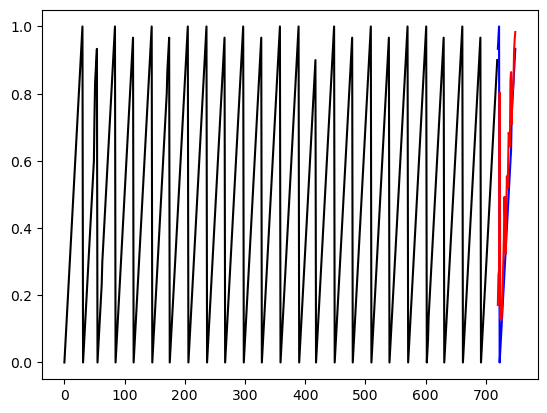

In [ ]:
for i in range(8):
    st.output_and_show(t1,train_dataset[0][0],train_dataset[0][2],device_id,i)

R^2 tensor(-0.4440)


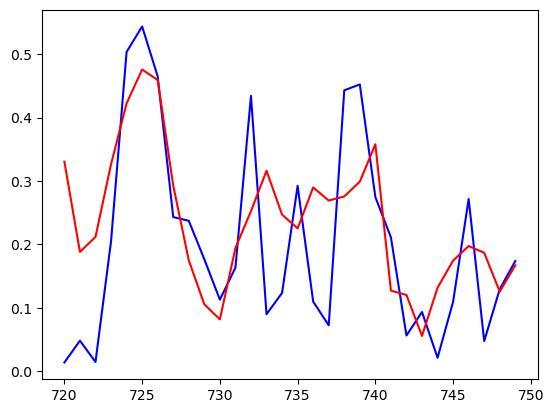

R^2 tensor(-2.0237)


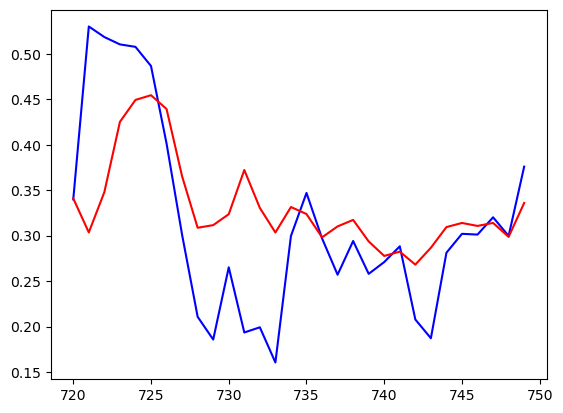

R^2 tensor(-0.5531)


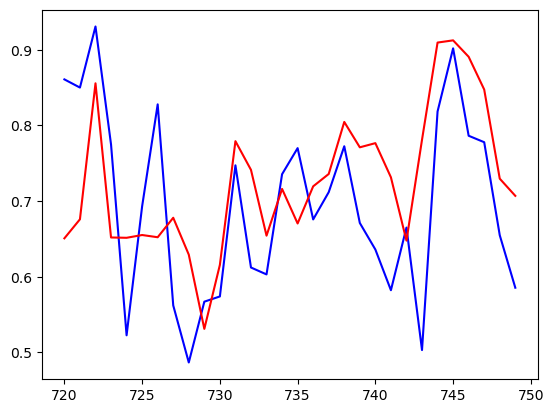

R^2 tensor(-0.1901)


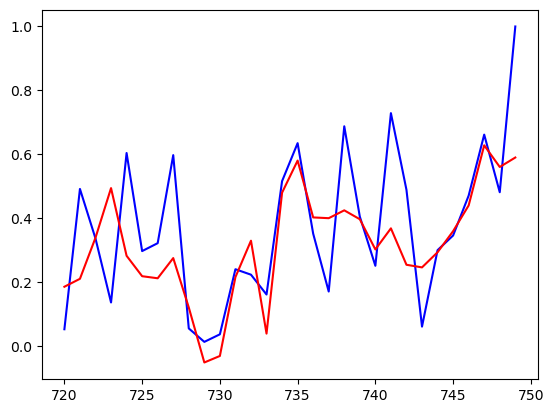

R^2 tensor(-8.7648)


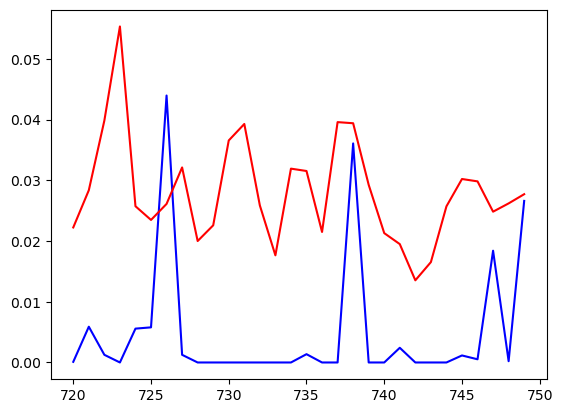

R^2 tensor(-350.7432)


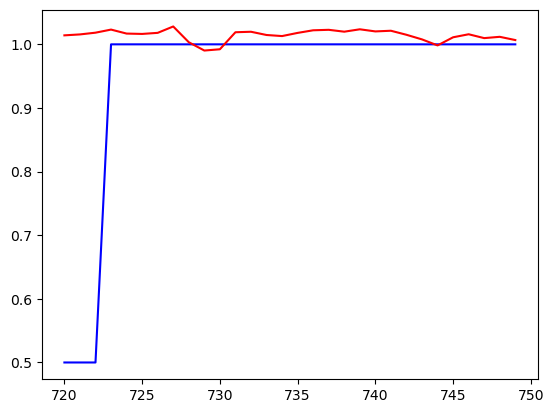

R^2 tensor(-123.3104)


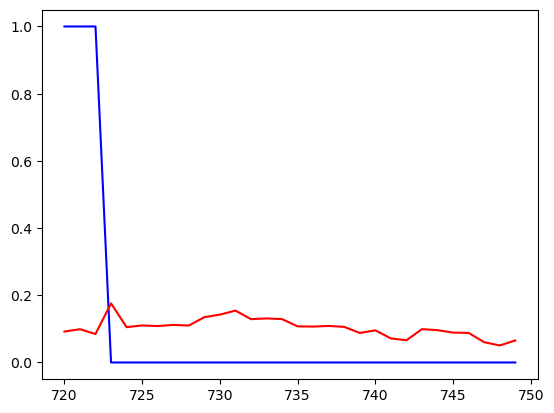

R^2 tensor(-0.1664)


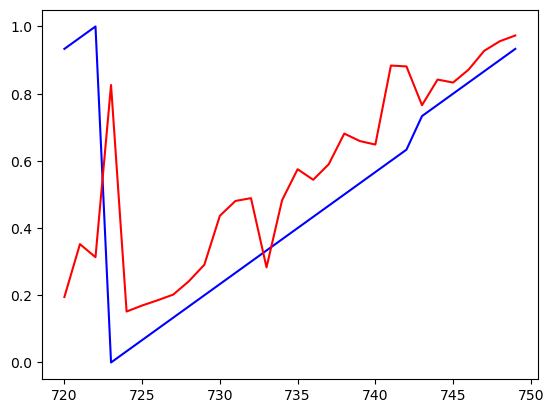

In [ ]:
for i in range(8):
    st.output_and_show_only_prediction(t1,train_dataset[0][0],train_dataset[0][2],device_id,i)

In [ ]:
len(t1.encoder_stack.encoders[0].mha.heads)

8

torch.Size([30, 8])
torch.Size([1, 30, 8])


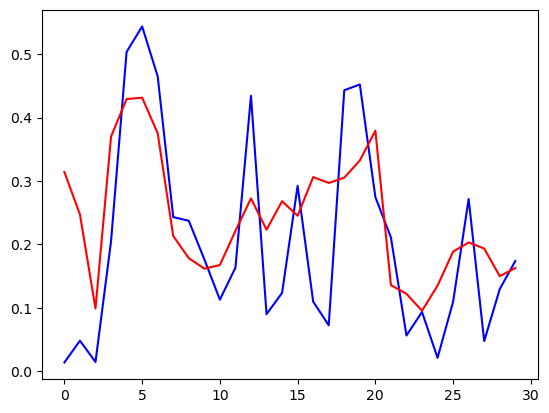

torch.Size([30, 8])
torch.Size([1, 30, 8])


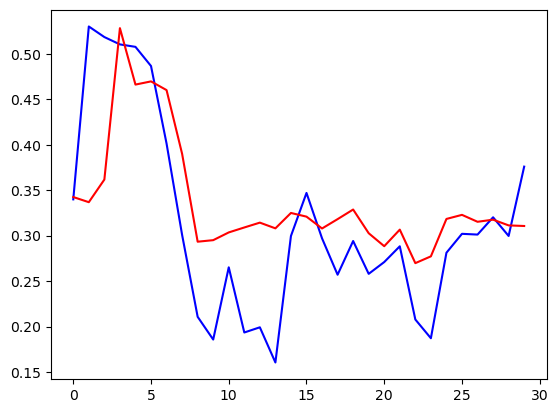

torch.Size([30, 8])
torch.Size([1, 30, 8])


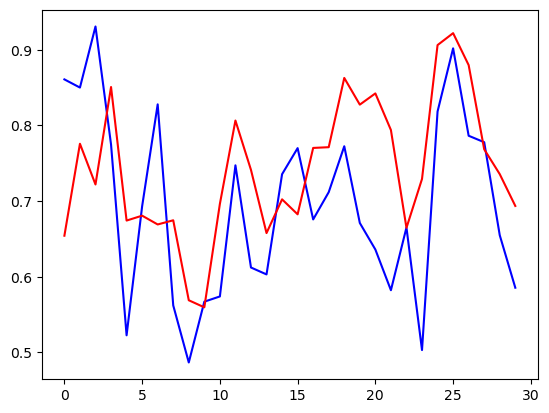

torch.Size([30, 8])
torch.Size([1, 30, 8])


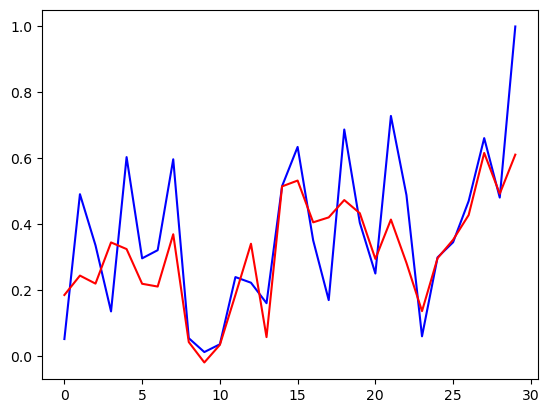

torch.Size([30, 8])
torch.Size([1, 30, 8])


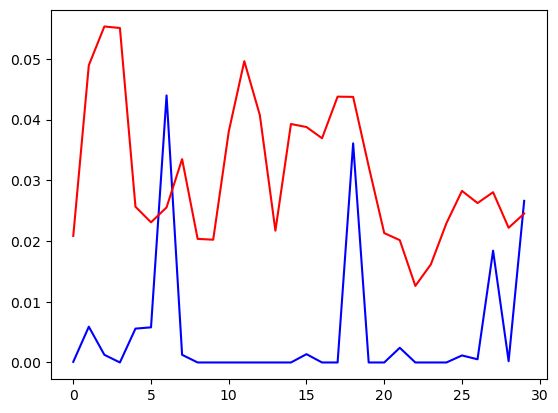

torch.Size([30, 8])
torch.Size([1, 30, 8])


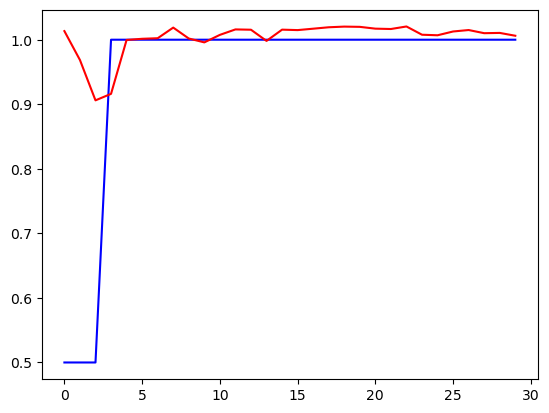

torch.Size([30, 8])
torch.Size([1, 30, 8])


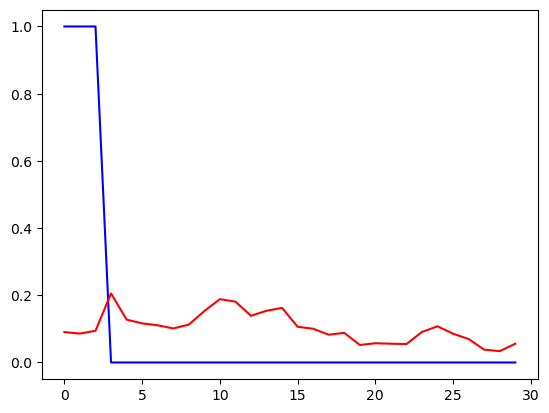

torch.Size([30, 8])
torch.Size([1, 30, 8])


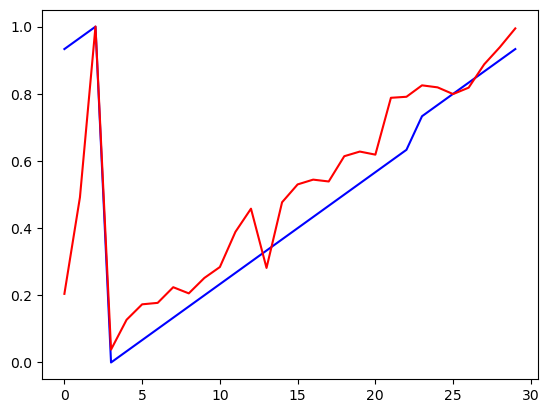

In [ ]:
for i in range(8):
    st.long_range_output_and_show(t1,train_dataset[0][0],train_dataset[0][2],device_id,i)